In [1]:
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm

import gensim
from gensim.utils import simple_preprocess

# sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [2]:
paths = [
    "Corona_NLP_train.csv", "Corona_NLP_test.csv"
]
for p in paths:
    if os.path.exists(p):
        df = pd.read_csv(p, encoding='latin1')
        print("Loaded", p)
        break
else:
    raise FileNotFoundError("Не знайдено файл датасету. Завантаж файл з Kaggle і помістіть у робочу директорію.")

df.head()

Loaded Corona_NLP_train.csv


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
print(df.columns)
for candidate in ['Original Tweet', 'OriginalTweet', 'tweet', 'text', 'Tweet', 'Tweet At', 'Original_Tweet', 'OriginalTweet']:
    if candidate in df.columns:
        text_col = candidate
        break
else:
    raise ValueError("Не знайдено колонки з текстом. Перевір назви колонок: ", df.columns)

for candidate in ['Sentiment', 'SentimentText', 'Label', 'label', 'Sentiment ']:
    if candidate in df.columns:
        label_col = candidate
        break
else:
    label_col = 'Sentiment'

print("text_col:", text_col, "label_col:", label_col)

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')
text_col: OriginalTweet label_col: Sentiment


In [4]:
stop_words = set(stopwords.words('english'))

def clean_and_tokenize(text):
    if pd.isna(text):
        return []
    text = str(text).lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'rt\b', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = simple_preprocess(text, deacc=True, min_len=2)
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

print(clean_and_tokenize("RT @user: COVID-19 is terrible!"))

['covid', 'terrible']


In [5]:
# Tokenize and split
df['tokens'] = df[text_col].progress_apply(clean_and_tokenize)
df = df[df['tokens'].map(len) > 0].reset_index(drop=True)

le = LabelEncoder()
df['y'] = le.fit_transform(df[label_col].astype(str))
print("Classes:", list(le.classes_))

X = df[text_col].values
y = df['y'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=RANDOM_STATE)
print("Train:", len(X_train), "Test:", len(X_test))

100%|██████████| 41157/41157 [00:06<00:00, 6265.01it/s]


Classes: ['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive']
Train: 32897 Test: 8225


In [6]:
#  Word2Vec transformer for Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=300, window=5, min_count=2, workers=4, epochs=10, sg=0):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.epochs = epochs
        self.sg = sg
        self.w2v_model_ = None

    def fit(self, X, y=None):
        sentences = [clean_and_tokenize(doc) for doc in X]
        sentences = [s for s in sentences if len(s) > 0]
        self.w2v_model_ = gensim.models.Word2Vec(
            sentences=sentences,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            workers=self.workers,
            sg=self.sg,
            epochs=self.epochs
        )
        self.kv_ = self.w2v_model_.wv
        return self

    def transform(self, X):
        vectors = np.zeros((len(X), self.vector_size), dtype=float)
        for i, doc in enumerate(X):
            tokens = clean_and_tokenize(doc)
            vecs = [self.kv_[w] for w in tokens if w in self.kv_]
            if len(vecs) > 0:
                vectors[i, :] = np.mean(vecs, axis=0)
            else:
                vectors[i, :] = np.zeros(self.vector_size)
        return vectors

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y)
        return self.transform(X)

In [7]:
# Classifiers and PCA settings
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    "SVM": SVC(kernel='linear', probability=False, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    "GaussianNB": GaussianNB()
}

pca_variants = [None, 50, 100, 200]
EMBED_SIZE = 300

In [8]:
# Train & evaluate
from sklearn.metrics import precision_recall_fscore_support

results = []

for pca_n in pca_variants:
    for clf_name, clf in classifiers.items():
        print(f"Training {clf_name} | PCA={pca_n}")
        steps = []
        steps.append(('w2v', Word2VecVectorizer(vector_size=EMBED_SIZE, epochs=10, workers=4)))
        if pca_n is not None:
            steps.append(('pca', PCA(n_components=pca_n, random_state=RANDOM_STATE)))
        steps.append(('clf', clf))
        pipe = Pipeline(steps)

        pipe.fit(X_train, y_train)

        y_pred = pipe.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True, zero_division=0)
        cm = confusion_matrix(y_test, y_pred)

        res = {
            'model': clf_name,
            'pca_n': 'None' if pca_n is None else pca_n,
            'accuracy': acc,
            'report': report,
            'confusion_matrix': cm
        }
        results.append(res)

        model_fname = f"pipeline_{clf_name}_pca_{'None' if pca_n is None else pca_n}.joblib"
        joblib.dump(pipe, model_fname)
        print(f"Saved pipeline to {model_fname}. Accuracy: {acc:.4f}")

Training LogisticRegression | PCA=None
Saved pipeline to pipeline_LogisticRegression_pca_None.joblib. Accuracy: 0.4205
Training SVM | PCA=None
Saved pipeline to pipeline_SVM_pca_None.joblib. Accuracy: 0.4128
Training RandomForest | PCA=None
Saved pipeline to pipeline_RandomForest_pca_None.joblib. Accuracy: 0.4246
Training GaussianNB | PCA=None
Saved pipeline to pipeline_GaussianNB_pca_None.joblib. Accuracy: 0.3089
Training LogisticRegression | PCA=50
Saved pipeline to pipeline_LogisticRegression_pca_50.joblib. Accuracy: 0.3982
Training SVM | PCA=50
Saved pipeline to pipeline_SVM_pca_50.joblib. Accuracy: 0.3774
Training RandomForest | PCA=50
Saved pipeline to pipeline_RandomForest_pca_50.joblib. Accuracy: 0.4180
Training GaussianNB | PCA=50
Saved pipeline to pipeline_GaussianNB_pca_50.joblib. Accuracy: 0.3336
Training LogisticRegression | PCA=100
Saved pipeline to pipeline_LogisticRegression_pca_100.joblib. Accuracy: 0.4150
Training SVM | PCA=100
Saved pipeline to pipeline_SVM_pca_100.j

In [13]:
# Collect metrics into DataFrame
rows = []
for r in results:
    acc = r['accuracy']
    rep = r['report']
    macro_f1 = rep.get('macro avg', {}).get('f1-score', None)
    for cls in le.classes_:
        cls_prec = rep.get(cls, {}).get('precision', None)
        cls_rec = rep.get(cls, {}).get('recall', None)
        cls_f1 = rep.get(cls, {}).get('f1-score', None)
        rows.append({
            'model': r['model'],
            'pca_n': r['pca_n'],
            'accuracy': acc,
            'macro_f1': macro_f1,
            'class': cls,
            'precision': cls_prec,
            'recall': cls_rec,
            'f1': cls_f1
        })

metrics_df = pd.DataFrame(rows)
metrics_df_pivot = metrics_df.pivot_table(index=['model','pca_n'], columns='class', values=['precision','recall','f1'])
metrics_df_pivot

f1                               \
class                    Extremely Negative Extremely Positive  Negative   
model              pca_n                                                   
GaussianNB         50              0.347277           0.399864  0.255754   
                   100             0.328456           0.401387  0.231806   
                   200             0.319277           0.376597  0.198020   
                   None            0.348071           0.390572  0.217421   
LogisticRegression 50              0.334343           0.393279  0.365389   
                   100             0.357870           0.406221  0.380744   
                   200             0.361244           0.412362  0.387429   
                   None            0.354340           0.411519  0.380282   
RandomForest       50              0.334683           0.382294  0.380817   
                   100             0.325678           0.380105  0.397738   
                   200             0.306497           0.370451  0.397427   
                   None            0.347661           0.403566  0.393545   
SVM                50              0.026690           0.324960  0.371713   
                   100             0.191635           0.370483  0.388473   
                   200             0.219219           0.368640  0.401083   
                   None            0.210766           0.369263  0.400451   

                                                      precision  \
class                      Neutral  Positive Extremely Negative   
model              pca_n                                          
GaussianNB         50     0.389964  0.284492           0.259093   
                   100    0.367609  0.247635           0.226987   
                   200    0.360692  0.229299           0.213975   
                   None   0.412669  0.126746           0.265170   
LogisticRegression 50     0.461035  0.408512           0.497297   
                   100    0.486133  0.420034           0.520000   
                   200    0.497534  0.435292           0.524306   
                   None   0.497835  0.429413           0.508532   
RandomForest       50     0.489682  0.442715           0.642487   
                   100    0.491278  0.450248           0.686217   
                   200    0.483895  0.467752           0.678125   
                   None   0.493819  0.441036           0.565844   
SVM                50     0.447863  0.429309           0.535714   
                   100    0.487384  0.436080           0.575342   
                   200    0.486728  0.437500           0.618644   
                   None   0.487805  0.443184           0.623318   

                                                                           \
class                    Extremely Positive  Negative   Neutral  Positive   
model              pca_n                                                    
GaussianNB         50              0.362854  0.349650  0.363995  0.365385   
                   100             0.409913  0.349593  0.332630  0.358506   
                   200             0.414701  0.331754  0.315738  0.373149   
                   None            0.286622  0.340129  0.391026  0.285714   
LogisticRegression 50              0.493729  0.358564  0.463768  0.349409   
                   100             0.515679  0.367778  0.466228  0.370606   
                   200             0.530249  0.377693  0.472482  0.382851   
                   None            0.535024  0.366917  0.474087  0.379322   
RandomForest       50              0.573152  0.359964  0.529101  0.360828   
                   100             0.620513  0.373451  0.542027  0.361657   
                   200             0.660853  0.376864  0.552676  0.368090   
                   None            0.533499  0.376845  0.522529  0.369135   
SVM                50              0.556777  0.330972  0.471562  0.346412   
                   100             0.568750  0.353281  0.478370  0.366786   
             

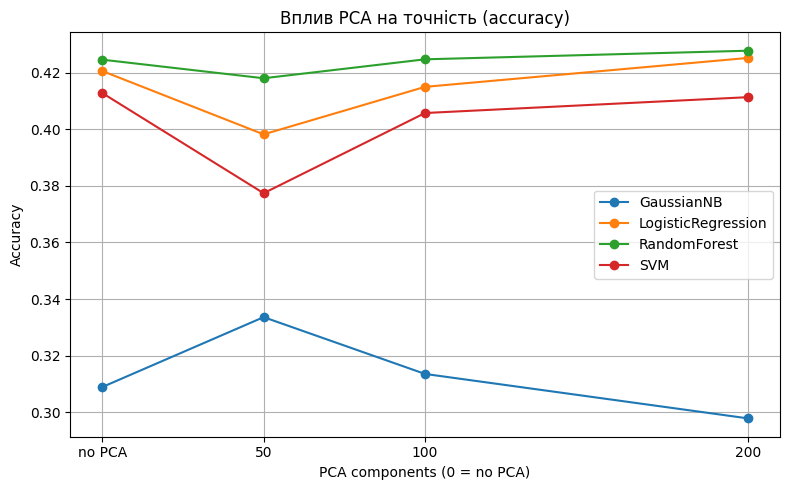

In [14]:
# Plot accuracy vs PCA components for each model
acc_df = metrics_df.groupby(['model','pca_n'])['accuracy'].first().reset_index()

plt.figure(figsize=(8,5))
for model in acc_df['model'].unique():
    dfm = acc_df[acc_df['model']==model].copy()
    dfm['pca_plot'] = dfm['pca_n'].apply(lambda x: 0 if x=='None' else int(x))
    dfm = dfm.sort_values('pca_plot')
    plt.plot(dfm['pca_plot'], dfm['accuracy'], marker='o', label=model)

plt.xticks([0,50,100,200], labels=['no PCA','50','100','200'])
plt.xlabel("PCA components (0 = no PCA)")
plt.ylabel("Accuracy")
plt.title("Вплив PCA на точність (accuracy)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Best: {'model': 'RandomForest', 'pca_n': 200, 'accuracy': 0.4277203647416413}


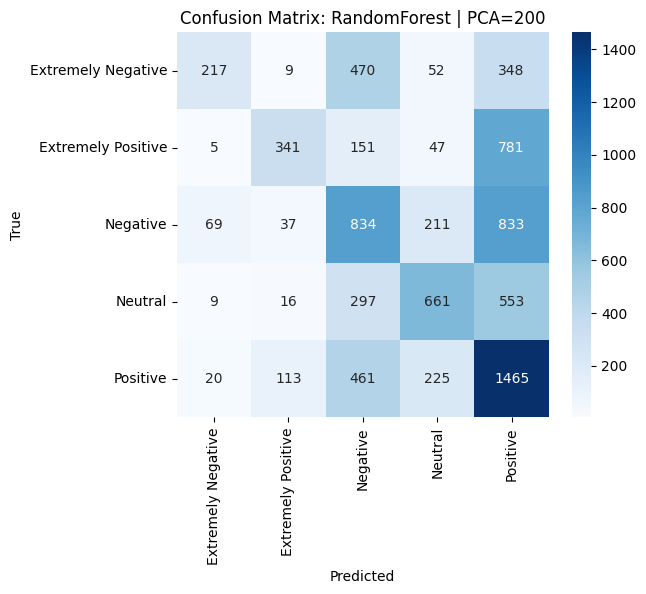

                    precision    recall  f1-score   support

Extremely Negative       0.68      0.20      0.31      1096
Extremely Positive       0.66      0.26      0.37      1325
          Negative       0.38      0.42      0.40      1984
           Neutral       0.55      0.43      0.48      1536
          Positive       0.37      0.64      0.47      2284

          accuracy                           0.43      8225
         macro avg       0.53      0.39      0.41      8225
      weighted avg       0.49      0.43      0.42      8225



In [15]:
# Confusion Matrix for the best model
acc_df = metrics_df.groupby(['model','pca_n'])['accuracy'].first().reset_index()
best = acc_df.sort_values('accuracy', ascending=False).iloc[0]
print("Best:", best.to_dict())

best_model_name = best['model']
best_pca = best['pca_n']
best_fname = f"pipeline_{best_model_name}_pca_{'None' if best_pca=='None' else best_pca}.joblib"
pipe_best = joblib.load(best_fname)

y_pred_best = pipe_best.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix: {best_model_name} | PCA={best_pca}")
plt.show()

print(classification_report(y_test, y_pred_best, target_names=le.classes_, zero_division=0))

In [16]:
# Predict new tweet example
def predict_tweet(text, pipeline):
    pred_idx = pipeline.predict([text])[0]
    return le.inverse_transform([pred_idx])[0]

example = "I got vaccinated today! Feeling hopeful."
print("Prediction:", predict_tweet(example, pipe_best))

Prediction: Positive
